# 6. Baby Names

<img style="float:right" width="400" src="https://www.todaysparent.com/wp-content/uploads/2017/02/How-to-name-your-baby...without-the-stress.jpg">

In this project we'll analyze the Baby Names data provided by the the US Government to look at some interesting things about kids names.

First, lets get the baby names data.  You can find it yourself at https://www.ssa.gov/oact/babynames/limits.html

> This project is based on example in Ch. 14.3 of [Python for Data Analysis, 2nd Ed.](https://wesmckinney.com/pages/book.html)

In [1]:
# !git clone https://github.com/mblackstock/datasets.git
# !ls

# Understanding data

In [2]:
import pandas as pd

starting_path = 'datasets/names'
names1880 = pd.read_csv(starting_path+'/yob1880.txt', names=['name','sex','births'])
names1880

,name,sex,births
0,Mary,F,7065
1,Anna,F,2604
2,Emma,F,2003
3,Elizabeth,F,1939
4,Minnie,F,1746
...,...,...,...
1995,Woodie,M,5
1996,Worthy,M,5
1997,Wright,M,5
1998,York,M,5


We can manipulate the data by summing up the number of births by sex:

In [3]:
names1880.groupby('sex').births.sum()

sex
F     90994
M    110490
Name: births, dtype: int64

# Loading data from multiple files

In this data set, all of the birth data is split up into different files by year, so if we want to analyse all of the data together, we can load them all up using a for loop.

In [4]:
years = range(1880, 2019)

pieces = []
columns = ['name', 'sex', 'births']

for year in years:
  path = starting_path+'/yob%d.txt' % year
  frame = pd.read_csv(path, names=columns)
  frame['year'] = year    # add a new column to the data frame
  pieces.append(frame)


Then we concatenate all of the pieces to make one big data frame

In [30]:
# now concatenate all of the pieces together into one big data frame
names = pd.concat(pieces, ignore_index=True)
names[:20]

,name,sex,births,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880
5,Margaret,F,1578,1880
6,Ida,F,1472,1880
7,Alice,F,1414,1880
8,Bertha,F,1320,1880
9,Sarah,F,1288,1880


# Analysis using pivot_table

Now say that we wanted to use this data to see how many babies were born in each year by sex.  We can use the pivot_table function to sum up the number of births by year like this:

In [9]:
total_births = names.pivot_table('births', index='year',columns='sex', aggfunc=sum)
total_births[:10]

sex,F,M
year,,
1880,90994,110490
1881,91953,100743
1882,107847,113686
1883,112319,104625
1884,129019,114442
1885,133055,107799
1886,144533,110784
1887,145982,101412
1888,178622,120851


Now we have a `DataFrame` where the index is year, and the columns are the number of male and female births.

Lets plot this data!

<AxesSubplot:title={'center':'Total births by sex and year'}, xlabel='year'>

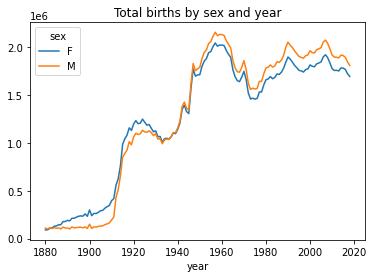

In [10]:
total_births.plot(title='Total births by sex and year')

# Group using functions

Lets add a column that contains the popularity of a given name relative to the total number of births in a given year.  Lets call it 'popularity'.  For example, if the popularity is 0.02 that would mean that 2% of the births were given that name.

In [29]:
names

name sex  births  year  popularity
year sex                                               
1880 F   0           Mary   F    7065  1880    0.077642
         1           Anna   F    2604  1880    0.028617
     M   942         John   M    9655  1880    0.087383
         943      William   M    9532  1880    0.086270
1881 F   2000        Mary   F    6919  1881    0.075245
...                   ...  ..     ...   ...         ...
2017 M   1911057     Noah   M   18446  2017    0.009995
2018 F   1925285     Emma   F   18757  2018    0.011068
         1925286   Olivia   F   17993  2018    0.010618
     M   1943385     Liam   M   19915  2018    0.011008
         1943386     Noah   M   18350  2018    0.010143

[556 rows x 5 columns]

In [35]:
# aggregate group
def sum_births(group):
    return group.births.sum()

# add a new column to the group
def duh(group):
    group['test'] = 'duh'
    return group

# return subset of the group
def first_2(group):
    return group[:2]

# add a new column to the group
def add_popularity(group):
    group['popularity'] = group.births/group.births.sum()
    return group

#names.groupby(['year', 'sex']).apply(sum_births)
#names.groupby(['year', 'sex']).apply(duh)
#names.groupby(['year', 'sex']).apply(first_2)

# note that it is the popularity for that year
names = names.groupby(['year', 'sex']).apply(add_popularity)
names

Note the use of the `add_popularity` function that we used in the `groupby` method.  We passed in the function `add_popularity` so that `groupby` then calls the function with each group in turn, where each group is also a DataFrame.

We can see that the popularity of Mary in 1880 was pretty high, whereas Zzyzx is the lowest for 2018.

When we do a group operation like this, its good to check that it sums up OK to sanity check.  In this case all of the names in the group by should add up to 1.0.

In [36]:
names.groupby(['year', 'sex']).popularity.sum()

year  sex
1880  F      1.0
      M      1.0
1881  F      1.0
      M      1.0
1882  F      1.0
            ... 
2016  M      1.0
2017  F      1.0
      M      1.0
2018  F      1.0
      M      1.0
Name: popularity, Length: 278, dtype: float64

Now that we have the popularity of each name for girls and boys for each year, lets use only the top 1000 names for each year to make the data smaller for further analysis, and remove any names that are irrelevant.

To do that we use another groupby function.

In [10]:
def get_top1000(group):
    return group.sort_values(by='births', ascending=False)[:1000]

grouped = names.groupby(['year', 'sex'])
top1000 = grouped.apply(get_top1000)
# drop the index since we don't need it
top1000.reset_index(inplace=True, drop=True)
top1000

,name,sex,births,year,popularity
0,Mary,F,7065,1880,0.077642
1,Anna,F,2604,1880,0.028617
2,Emma,F,2003,1880,0.022012
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188
...,...,...,...,...,...
277872,Coleman,M,208,2018,0.000115
277873,Bear,M,207,2018,0.000114
277874,Gus,M,207,2018,0.000114
277875,Kabir,M,207,2018,0.000114


# Naming Trends

Now that we have the full dataset and the top 1000 names for each year in hand, we can look at naming trends.  First, we can split them into boys and girls

In [11]:
boys = top1000[top1000.sex == 'M']
girls = top1000[top1000.sex == 'F']

now can try to plot the popularity of certain names over time, but we need to get our data in the right format.  lets pivot to do that

In [12]:
total_births = top1000.pivot_table('births', index='year', columns='name', aggfunc=sum)
total_births.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139 entries, 1880 to 2018
Columns: 7176 entries, Aaden to Zyaire
dtypes: float64(7176)
memory usage: 7.6 MB


Now lets graph each one separately using the subplots feature.

Try your name to see how popular it is!

array([<AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
       <AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>],
      dtype=object)

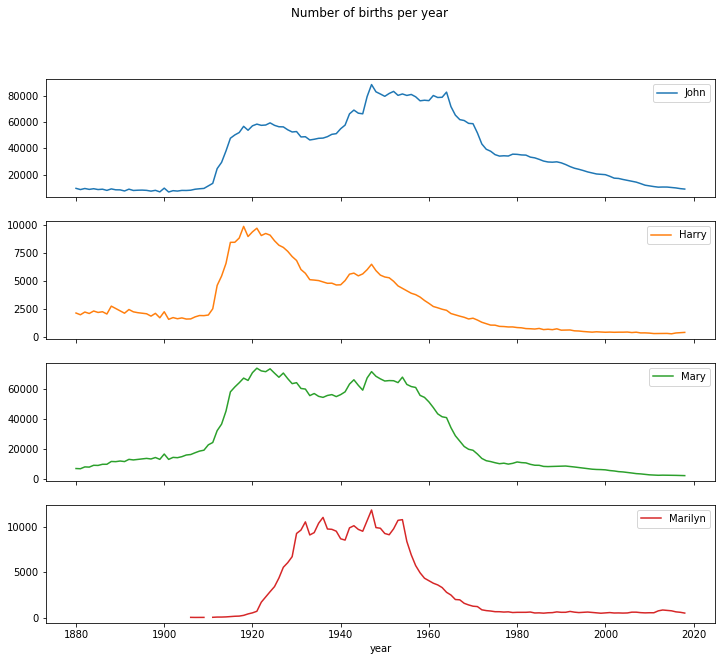

In [13]:
subset = total_births[['John', 'Harry', 'Mary', 'Marilyn']]
subset.plot(subplots=True, figsize=(12,10), grid=False, title="Number of births per year")

From looking at this, you might think that the number of babies has decreased, but or that these names have gone out of style, but that's only part of the story.

## Name diversity

Lets measure the increase in naming diversity over the years, that is, the total percentage of names covered in the top1000 names

In [14]:
table = top1000.pivot_table('popularity', index='year', columns='sex', aggfunc=sum)

<AxesSubplot:title={'center':'Sum of popularity of names by year and sex'}, xlabel='year'>

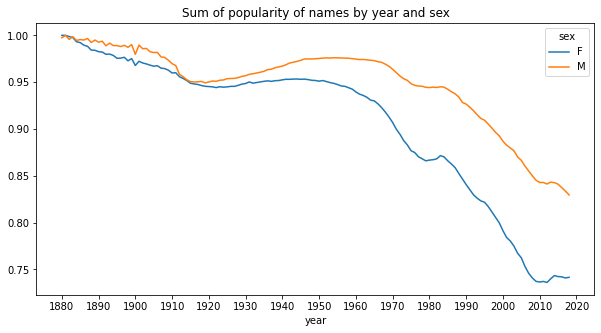

In [15]:
table.plot(title='Sum of popularity of names by year and sex', figsize=(10,5), xticks=range(1880, 2030, 10))

Interesting that the diversity of names has been increasing.  You can tell because the top 1000 names covers less and less of the total number of names.

To dig into this deeper, we can look at how many names there are in the top 50% of names every year.

First, lets look at the diversity in one year for boys


In [16]:
df = boys[boys.year == 2018]
df

,name,sex,births,year,popularity
276877,Liam,M,19915,2018,0.011008
276878,Noah,M,18350,2018,0.010143
276879,William,M,14590,2018,0.008064
276880,James,M,13589,2018,0.007511
276881,Oliver,M,13461,2018,0.007440
...,...,...,...,...,...
277872,Coleman,M,208,2018,0.000115
277873,Bear,M,207,2018,0.000114
277874,Gus,M,207,2018,0.000114
277875,Kabir,M,207,2018,0.000114


In [17]:
popularity_sum = df.sort_values(by='popularity', ascending=False).popularity.cumsum()
popularity_sum[:10]

276877    0.011008
276878    0.021151
276879    0.029215
276880    0.036726
276881    0.044167
276882    0.051598
276883    0.058759
276884    0.065741
276885    0.072635
276886    0.079490
Name: popularity, dtype: float64

find the index where the sum is 0.5

In [18]:
popularity_sum.values.searchsorted(0.5)

148

We can see that there are 148+1 names in the top 50 percentile of popular names in 2020.  If we look at 1900:

In [19]:
df = boys[boys.year == 1900]
popularity_sum = df.sort_values(by='popularity', ascending=False).popularity.cumsum()
popularity_sum.values.searchsorted(0.5)+1

25

In 1900, there were only 25 names in the top 50%.

Now that we have an idea of how to calculate this, lets plot it

In [20]:
def get_quantile_count(group, q=0.5):
    group = group.sort_values(by='popularity', ascending=False)
    return group.popularity.cumsum().values.searchsorted(q)+1

diversity = top1000.groupby(['year', 'sex']).apply(get_quantile_count)
diversity = diversity.unstack('sex')

<AxesSubplot:title={'center':'Number of popular names in the top 50%'}, xlabel='year'>

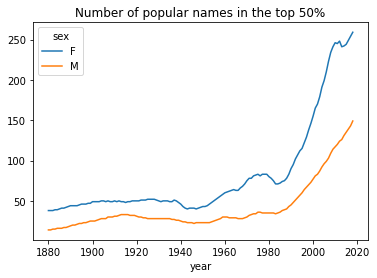

In [21]:
diversity.plot(title="Number of popular names in the top 50%")

# Boy to Girl Names

In [22]:
all_names = pd.Series(top1000.name.unique())
lesley_like = all_names[all_names.str.lower().str.contains('lesl')]


In [23]:
lesley_like

632     Leslie
2294    Lesley
4264    Leslee
4732     Lesli
6107     Lesly
dtype: object

In [24]:
filtered = top1000[top1000.name.isin(lesley_like)]

Now lets aggregate by sex and year

In [25]:
table = filtered.pivot_table('births', index='year', columns='sex', aggfunc=sum)

In [26]:
table = table.fillna(0)
table

sex,F,M
year,,
1880,8.0,79.0
1881,11.0,92.0
1882,9.0,128.0
1883,7.0,125.0
1884,15.0,125.0
...,...,...
2014,1276.0,0.0
2015,879.0,0.0
2016,804.0,0.0


sum along the columns, and divide each index

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.div.html

In [27]:
table = table.div(table.sum(axis=1), axis=0)

<AxesSubplot:xlabel='year'>

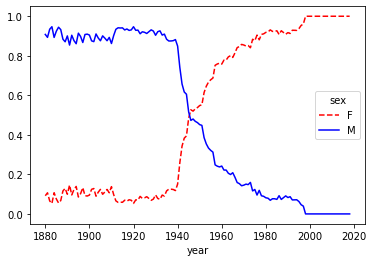

In [28]:
table.plot(style={'M':'b-','F':'r--'})

# Challenges

What's another name to analyse?  How about names like 'Tracey' (trac)?

```
tracey_like = all_names[all_names.str.lower().str.contains('trac')]
```
How can we clean the data to handle NaN when the name was never used?

```
table = table.fillna(0)
```

How popular was your name in the USA over this period?